# 불법 현수막 탐지 프로젝트 Main

### <시나리오>

* 촬영 데이터 입력
* Yolov8 현수막 추출
* OCR 텍스트 추출
* chatGPT 대분류
* Dataframe에 기록

##### 1) 마을버스/순찰차/순찰 시 GPS 기준 이동거리 5m 간격 촬영

In [135]:
import json

# 촬영된 데이터 format 예시
# 16개의 사진 데이터 
json_file_path = 'capture_data/meta_data.json'

with open(json_file_path, 'r') as json_file:
    meta_data = json.load(json_file)

# 카메라 촬영을 통해 필요한 데이터 요소
# id(고유키), filename(파일명), timestamp(날짜/시간), location(위도/경도)
meta_data

{'dataset_info': {'name': '불법 현수막 탐지 프로젝트 데이터셋',
  'version': '1.0',
  'description': '도로에서 촬영한 불법 현수막 탐지 데이터셋',
  'date_created': '2023-08-12T15:00:00.123456'},
 'data': [{'id': 1,
   'file_name': 'data_001.jpg',
   'timestamp': '2023-08-12T15:00:00.123456',
   'location': {'latitude': 37.123456, 'longitude': -122.789012}},
  {'id': 2,
   'file_name': 'data_002.jpg',
   'timestamp': '2023-08-12T15:05:00.123456',
   'location': {'latitude': 37.123501, 'longitude': -122.789012}},
  {'id': 3,
   'file_name': 'data_003.jpg',
   'timestamp': '2023-08-12T15:10:00.123456',
   'location': {'latitude': 37.123546, 'longitude': -122.789012}},
  {'id': 4,
   'file_name': 'data_004.jpg',
   'timestamp': '2023-08-12T15:15:00.123456',
   'location': {'latitude': 37.123591, 'longitude': -122.789012}},
  {'id': 5,
   'file_name': 'data_005.jpg',
   'timestamp': '2023-08-12T15:20:00.123456',
   'location': {'latitude': 37.123636, 'longitude': -122.789012}},
  {'id': 6,
   'file_name': 'data_006.jpg',
 

##### 2) yolov8 활용 데이터별(id별) 현수막 crop

In [136]:
# 학습한 모델 load

# https://stackoverflow.com/questions/24773109/how-to-downgrade-the-installed-version-of-pip-on-windows
# pip install torchvision==0.15.1
from ultralytics import YOLO
import torch
from datetime import datetime
import shutil
import os
from glob import glob
import time

# cpu
# device = 'cpu'

# gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

model = YOLO('models/08_13_banner576_best.pt')

cuda


In [143]:
import pandas as pd
from PIL import Image
import numpy as np

# DataFrame 정의

# <Columns>  
# Id(고유 키)
# Date(날짜) 
# Time(시간) 
# Location(위치) 
# Origin_img(원본사진) 
# Crop_imgs(detect된 사진들) 
# OCR_text(추출 텍스트)
# Category(현수막 종류) 
# Legality(합/불법)  


print(" meta data 요소 : ",meta_data['data'][0].keys())

df_data = []
for item in meta_data['data']:

    date_time = item['timestamp'].split("T")
    df_row = {
        'ID' : item['id'],
        'Date' : date_time[0],
        'Time' : date_time[1],
        'Location' : [item['location']['latitude'], item['location']['longitude']],
        'Origin_img' : np.array(Image.open('capture_data/'+item['file_name'])),
        'Detect_img' : [],
        'Crop_imgs' : [],
        'Crop_xywh' : [],
        'OCR_text' : [],
        'Category' : [],
        'Legality' : []
    }

    df_data.append(df_row)

df_report = pd.DataFrame(df_data)

# date_created : 데이터 수집한 날짜
date_created = meta_data['dataset_info']['date_created'].split("T")[0].split("-")
df_report.to_csv('reports/report_'+'_'.join(date_created)+'.csv')
df_report

 meta data 요소 :  dict_keys(['id', 'file_name', 'timestamp', 'location'])


,ID,Date,Time,Location,Origin_img,Detect_img,Crop_imgs,Crop_xywh,OCR_text,Category,Legality
0,1,2023-08-12,15:00:00.123456,"[37.123456, -122.789012]","[[[76, 104, 105], [74, 102, 103], [84, 112, 11...",[],[],[],[],[],[]
1,2,2023-08-12,15:05:00.123456,"[37.123501, -122.789012]","[[[38, 37, 35], [46, 45, 43], [73, 73, 71], [8...",[],[],[],[],[],[]
2,3,2023-08-12,15:10:00.123456,"[37.123546, -122.789012]","[[[21, 44, 24], [5, 28, 8], [9, 31, 10], [14, ...",[],[],[],[],[],[]
3,4,2023-08-12,15:15:00.123456,"[37.123591, -122.789012]","[[[60, 102, 127], [101, 143, 168], [111, 153, ...",[],[],[],[],[],[]
4,5,2023-08-12,15:20:00.123456,"[37.123636, -122.789012]","[[[175, 205, 205], [169, 191, 188], [79, 92, 8...",[],[],[],[],[],[]
5,6,2023-08-12,15:25:00.123456,"[37.123681, -122.789012]","[[[95, 107, 93], [101, 111, 100], [108, 118, 1...",[],[],[],[],[],[]
6,7,2023-08-12,15:30:00.123456,"[37.123726, -122.789012]","[[[113, 113, 105], [97, 97, 89], [86, 86, 78],...",[],[],[],[],[],[]
7,8,2023-08-12,15:35:00.123456,"[37.123771, -122.789012]","[[[26, 31, 37], [28, 33, 39], [32, 37, 41], [4...",[],[],[],[],[],[]
8,9,2023-08-12,15:40:00.123456,"[37.123816, -122.789012]","[[[251, 248, 243], [249, 248, 243], [248, 251,...",[],[],[],[],[],[]
9,10,2023-08-12,15:45:00.123456,"[37.123861, -122.789012]","[[[123, 159, 89], [109, 144, 80], [175, 208, 1...",[],[],[],[],[],[]


In [138]:
class_names = ['banner','frame']
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']

predict_path = 'runs/detect/predict/'
predict_detect_path = predict_path
predict_crop_banner_path = predict_path+class_names[0]
predict_crop_frame_path = predict_path+class_names[1]

log_path = 'logs/'

In [139]:
def move_all_img(source_folder, destination_folder):
    # source_folder 내의 모든 항목을 destination_folder로 이동
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)
        shutil.move(source_item, destination_item)

In [140]:
def move_img(source_path, destination_path):
    # 목적지 경로가 존재하지 않으면 생성
    print(destination_path)
    print('/'.join(destination_path.split('/')[:-1]))
    # print(destination_path)
    if not os.path.exists(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/')):
        os.makedirs(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/'))
    
    # 파일 이동
    shutil.move(source_path, destination_path)

In [146]:
def yolo_run(img):
    
    # GPU predict 시, show=False/save=True로 설정 
    results = model.predict(
                            source=img, # 디렉토리 (capture_data/)
                            conf=0.5, # confidence threshold for detection (오탐지 시 재설정)
                            save=True,  # Detect 결과 저장 (runs/detect/predict)
                            device=device, # device 설정
                            show=False, # window 창으로 show
                            save_crop=True # Detect된 Obeject 사진 저장 (runs/detect/predict/crops)
                            )

    for idx,result in enumerate(results):
        now = datetime.now()
        now_time = str(now.year) + str(now.month) + str(now.day) + '_' + str(now.hour) + str(now.minute) + str(now.second)

        boxes = result.boxes
        saved_img = ''

        print("================================= Predict 결과 =================================")

        file_name = img.split('\\')[-1]
        img_name = file_name[:-4]
        ext_name = file_name[-4:]

        # 데이터이름+날짜시간
        data_datetime_dir = log_path+now_time+'_'+img_name+'/'

        # predict된 결과를 'logs/'에 저장
        move_all_img(predict_path,data_datetime_dir)
        # 원본 이미지 저장
        os.makedirs(data_datetime_dir+'origin_img/')
        shutil.copyfile(img,data_datetime_dir+'origin_img/'+img.split('\\')[-1])
        # detect된 이미지 저장
        move_img(data_datetime_dir+file_name,data_datetime_dir+'detect_img/'+file_name)
        # crop_imgs로 폴더명 변경
        os.rename(data_datetime_dir+'crops', data_datetime_dir+'crop_imgs')

        for idx,box in enumerate(boxes):

            print()
            print(" "+str(idx+1) + "번째 결과")
            print(" Detect 클래스 : ", class_names[int(box.cls)])
            print(" confidence 확률 : ", box.conf)
            print(" 중심x, 중심y, 너비, 높이 : ", box.xywh)
            print()
            print("================================================================================")

##### 로그 저장 디렉토리

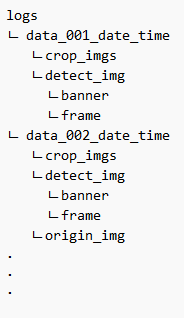

#### predict 실행

In [147]:
# imgs = 이미지 데이터 경로

imgs = glob('capture_data/*.jpg')

for img in imgs:
    yolo_run(img)


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_001.jpg: 384x640 3 banners, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_002.jpg: 416x640 3 banners, 1 frame, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_003.jpg: 448x640 5 banners, 24.0ms


================================= Predict 결과 =================================
logs/2023812_23312_data_001/detect_img/data_001.jpg
logs/2023812_23312_data_001/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6982], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[458.5684,  93.7201, 186.9148, 140.7925]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6470], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[308.0838, 198.8755, 393.7336, 313.2115]], device='cuda:0')


 3번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6176], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[313.6124, 263.9198, 381.8876, 162.5217]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23312_data_002/detect_img/data_002.jpg
logs/2023812_23312_data_002/detect_img

 1번째 결과
 Detect 클래스 :  frame
 confidence 확률 :  tensor([0.7058], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[319.3768, 207.7796, 547.5043,

Speed: 2.9ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_004.jpg: 384x640 13 banners, 2 frames, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict



================================= Predict 결과 =================================
logs/2023812_23312_data_003/detect_img/data_003.jpg
logs/2023812_23312_data_003/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.8259], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[156.0601, 171.6305, 210.7659,  39.7925]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.8172], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[452.4641, 140.0030, 236.1828,  43.5799]], device='cuda:0')


 3번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7863], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[167.7319, 207.6787, 193.0951,  32.0590]], device='cuda:0')


 4번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7778], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[155.0074, 241.7602, 222.7421,  33.2580]], device='cuda:0')


 5번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7660], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[466.7850, 188.3232, 214.1

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_005.jpg: 448x640 2 banners, 24.0ms
Speed: 4.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_006.jpg: 320x640 2 banners, 19.0ms
Speed: 2.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_007.jpg: 480x640 1 banner, 26.2ms
Speed: 3.1ms preprocess, 26.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_008.jpg: 384x640 1 banner, 21.0ms
Speed: 3.1ms preprocess, 21.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict



================================= Predict 결과 =================================
logs/2023812_23312_data_005/detect_img/data_005.jpg
logs/2023812_23312_data_005/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7029], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[737.5560, 306.5981, 956.6718, 151.4854]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6724], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[741.9000, 449.8803, 961.8842, 149.9865]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23312_data_006/detect_img/data_006.jpg
logs/2023812_23312_data_006/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6781], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[284.8708,  67.2189, 388.2400,  60.4286]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6511], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[279.9463, 130.2542, 398.9427

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_009.jpg: 320x640 1 banner, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_010.jpg: 480x640 1 banner, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_011.jpg: 416x640 6 banners, 1 frame, 21.0ms
Speed: 3.0ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict



================================= Predict 결과 =================================
logs/2023812_23313_data_009/detect_img/data_009.jpg
logs/2023812_23313_data_009/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.5343], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[279.3679, 149.8473, 558.7358,  96.8458]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23313_data_010/detect_img/data_010.jpg
logs/2023812_23313_data_010/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7686], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[133.4438,  50.2484, 189.0426,  89.6609]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23313_data_011/detect_img/data_011.jpg
logs/2023812_23313_data_011/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7703], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[417.4749, 162.3237,  76.4149,  

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_012.jpg: 608x640 8 banners, 1 frame, 29.0ms
Speed: 3.4ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_013.jpg: 384x640 2 banners, 27.6ms
Speed: 0.0ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict



================================= Predict 결과 =================================
logs/2023812_23313_data_012/detect_img/data_012.jpg
logs/2023812_23313_data_012/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7848], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[328.9728, 184.6086, 349.8607,  47.2674]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7692], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[331.9914, 321.6644, 352.7352,  38.0457]], device='cuda:0')


 3번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7539], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[333.9261, 352.9562, 352.8011,  37.9594]], device='cuda:0')


 4번째 결과
 Detect 클래스 :  frame
 confidence 확률 :  tensor([0.7497], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[328.6801, 262.2987, 381.4026, 369.3760]], device='cuda:0')


 5번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.7366], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[330.2668, 222.4726, 348.69

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_014.jpg: 384x640 1 banner, 18.0ms
Speed: 3.0ms preprocess, 18.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_015.jpg: 480x640 1 banner, 1 frame, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict

image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_016.jpg: 416x640 1 banner, 21.0ms
Speed: 3.0ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict


================================= Predict 결과 =================================
logs/2023812_23313_data_014/detect_img/data_014.jpg
logs/2023812_23313_data_014/detect_img

 1번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.5774], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[476.0788, 299.5050, 634.6932, 221.4940]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23313_data_015/detect_img/data_015.jpg
logs/2023812_23313_data_015/detect_img

 1번째 결과
 Detect 클래스 :  frame
 confidence 확률 :  tensor([0.7321], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[393.8020, 309.6951, 735.3344, 580.6098]], device='cuda:0')


 2번째 결과
 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.5114], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[419.2660, 431.1302, 615.3091,  99.9814]], device='cuda:0')

================================= Predict 결과 =================================
logs/2023812_23313_data_016/detect_img/data_016.jpg
logs/202381